Farm to Feed Recommender System
Challenge: Predict purchase probability and quantity for 1-week and 2-week horizons
Evaluation: 50% AUC (binary classification) + 50% MAE (quantity prediction)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, mean_absolute_error
import lightgbm as lgb

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
Pandas version: 2.3.1


 ============================================================================
 STEP 1: LOAD DATA WITH MEMORY OPTIMIZATION
 ============================================================================

In [8]:
def optimize_dtypes(df):
    """Optimize dataframe memory usage by converting to appropriate dtypes"""
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    
    return df

print("\n" + "="*70)
print("LOADING DATASETS")
print("="*70)

# Load smaller datasets
print("\n1. Loading customer data...")
customer_df = pd.read_csv('customer_data.csv')
customer_df['customer_created_at'] = pd.to_datetime(customer_df['customer_created_at'])
print(f"   Shape: {customer_df.shape}")
print(f"   Unique customers: {customer_df['customer_id'].nunique()}")

print("\n2. Loading SKU data...")
sku_df = pd.read_csv('sku_data.csv')
print(f"   Shape: {sku_df.shape}")
print(f"   Unique SKUs: {sku_df['product_unit_variant_id'].nunique()}")

print("\n3. Loading test data...")
test_df = pd.read_csv('Test.csv')
test_df['week_start'] = pd.to_datetime(test_df['week_start'])
test_df['customer_created_at'] = pd.to_datetime(test_df['customer_created_at'])
print(f"   Shape: {test_df.shape}")
print(f"   Date range: {test_df['week_start'].min()} to {test_df['week_start'].max()}")

print("\n4. Loading sample submission...")
sample_sub = pd.read_csv('SampleSubmission.csv')
print(f"   Shape: {sample_sub.shape}")

# Load training data with memory optimization
print("\n5. Loading training data (this may take a moment)...")
print("   Using memory-efficient loading...")

# Define dtypes for training data - exact columns from Train.csv
train_dtypes = {
    'ID': 'str',
    'customer_id': 'int32',
    'product_unit_variant_id': 'int32',
    'qty_this_week': 'float32',
    'num_orders_week': 'int16',
    'spend_this_week': 'float32',
    'purchased_this_week': 'int8',
    'product_id': 'int32',
    'grade_name': 'category',
    'unit_name': 'category',
    'product_grade_variant_id': 'int32',
    'selling_price': 'float32',
    'customer_category': 'category',
    'customer_status': 'category',
    'Target_qty_next_1w': 'float32',
    'Target_purchase_next_1w': 'int8',
    'Target_qty_next_2w': 'float32',
    'Target_purchase_next_2w': 'int8'
}

try:
    train_df = pd.read_csv('Train.csv', dtype=train_dtypes, parse_dates=['week_start', 'customer_created_at'])
    print(f"   ✓ Loaded successfully!")
    print(f"   Shape: {train_df.shape}")
    print(f"   Memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   Date range: {train_df['week_start'].min()} to {train_df['week_start'].max()}")
except FileNotFoundError:
    print("   ⚠ Train.csv not found. Please upload the file to continue.")
    print("   The notebook is ready to process it once uploaded.")
    train_df = None



LOADING DATASETS

1. Loading customer data...
   Shape: (463, 4)
   Unique customers: 463

2. Loading SKU data...
   Shape: (673, 6)
   Unique SKUs: 673

3. Loading test data...
   Shape: (275796, 11)
   Date range: 2025-09-22 00:00:00 to 2025-10-27 00:00:00

4. Loading sample submission...
   Shape: (275796, 5)

5. Loading training data (this may take a moment)...
   Using memory-efficient loading...
   ✓ Loaded successfully!
   Shape: (2114436, 20)
   Memory usage: 253.47 MB
   Date range: 2024-10-28 00:00:00 to 2025-09-08 00:00:00


============================================================================
STEP 2: EXPLORATORY DATA ANALYSIS
============================================================================


EXPLORATORY DATA ANALYSIS

1. Dataset Overview:
   Total records: 2,114,436
   Unique customers: 141
   Unique products: 326
   Date range: 315 days

2. Target Variable Analysis:

   1-Week Horizon:
   - Purchase rate: 2.06%
   - Avg quantity (when purchased): 52.38
   - Max quantity: 140400.00

   2-Week Horizon:
   - Purchase rate: 2.77%
   - Avg quantity (when purchased): 80.25
   - Max quantity: 270400.00


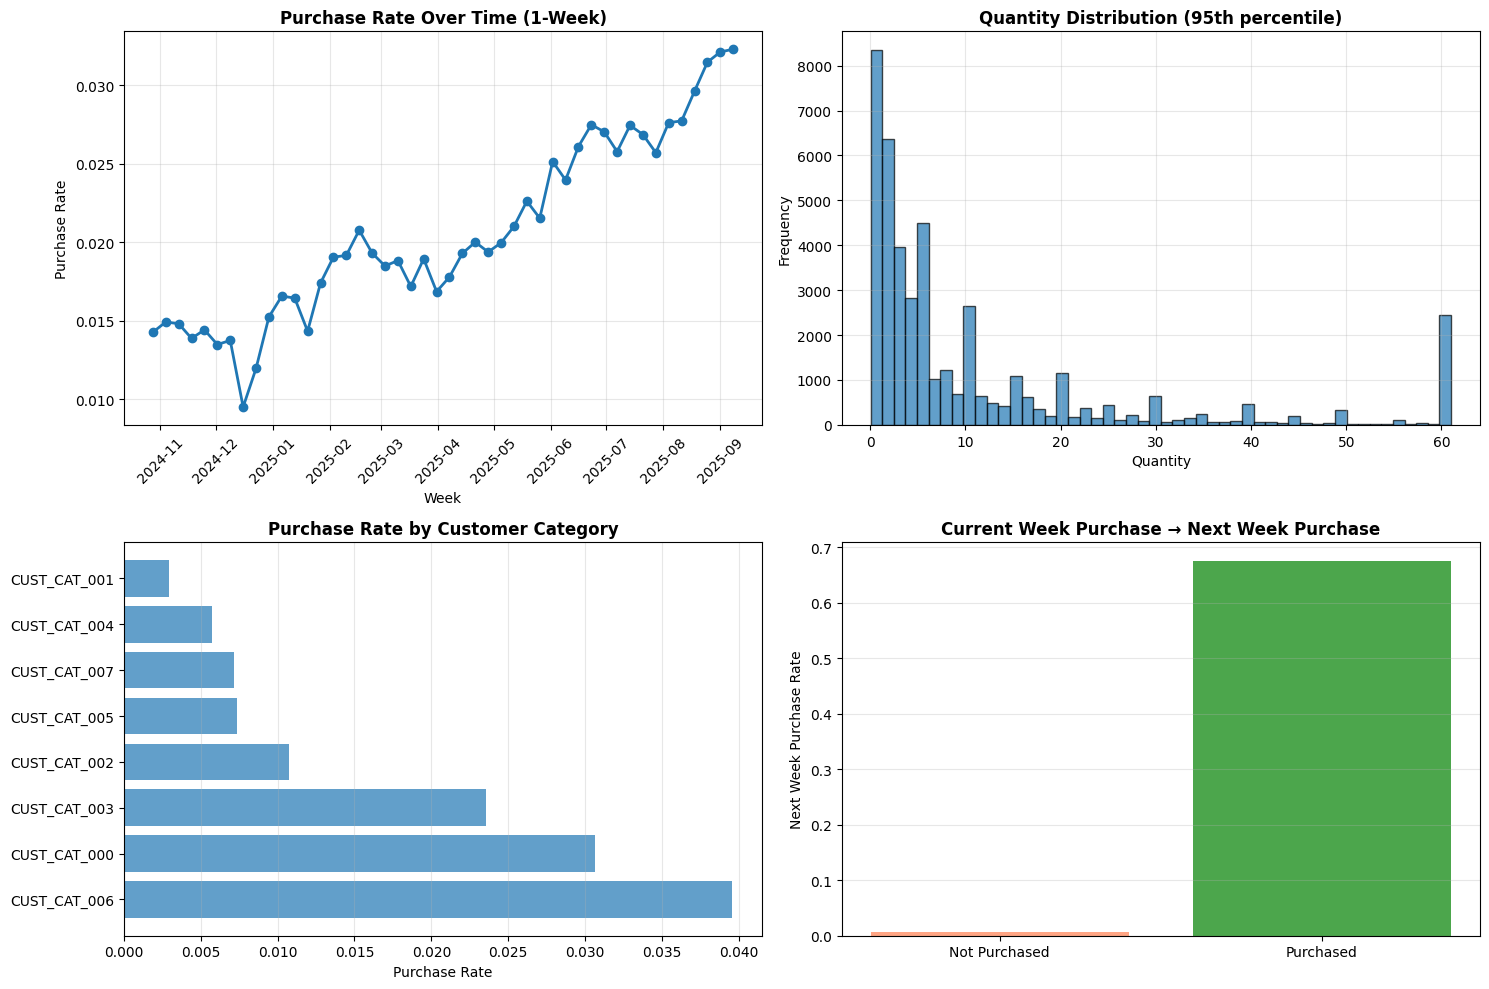

In [9]:
if train_df is not None:
    print("\n" + "="*70)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*70)
    
    # Basic statistics
    print("\n1. Dataset Overview:")
    print(f"   Total records: {len(train_df):,}")
    print(f"   Unique customers: {train_df['customer_id'].nunique():,}")
    print(f"   Unique products: {train_df['product_unit_variant_id'].nunique():,}")
    print(f"   Date range: {(train_df['week_start'].max() - train_df['week_start'].min()).days} days")
    
    # Target distributions
    print("\n2. Target Variable Analysis:")
    print(f"\n   1-Week Horizon:")
    print(f"   - Purchase rate: {train_df['Target_purchase_next_1w'].mean()*100:.2f}%")
    print(f"   - Avg quantity (when purchased): {train_df[train_df['Target_purchase_next_1w']==1]['Target_qty_next_1w'].mean():.2f}")
    print(f"   - Max quantity: {train_df['Target_qty_next_1w'].max():.2f}")
    
    print(f"\n   2-Week Horizon:")
    print(f"   - Purchase rate: {train_df['Target_purchase_next_2w'].mean()*100:.2f}%")
    print(f"   - Avg quantity (when purchased): {train_df[train_df['Target_purchase_next_2w']==1]['Target_qty_next_2w'].mean():.2f}")
    print(f"   - Max quantity: {train_df['Target_qty_next_2w'].max():.2f}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Purchase rate over time
    purchase_rate = train_df.groupby('week_start')['Target_purchase_next_1w'].mean()
    axes[0, 0].plot(purchase_rate.index, purchase_rate.values, marker='o', linewidth=2)
    axes[0, 0].set_title('Purchase Rate Over Time (1-Week)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Week')
    axes[0, 0].set_ylabel('Purchase Rate')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Quantity distribution
    qty_data = train_df[train_df['Target_qty_next_1w'] > 0]['Target_qty_next_1w']
    axes[0, 1].hist(qty_data.clip(upper=qty_data.quantile(0.95)), bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Quantity Distribution (95th percentile)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Quantity')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Customer category distribution
    customer_cat = train_df.groupby('customer_category')['Target_purchase_next_1w'].agg(['mean', 'count'])
    customer_cat = customer_cat.sort_values('mean', ascending=False)
    axes[1, 0].barh(customer_cat.index, customer_cat['mean'], alpha=0.7)
    axes[1, 0].set_title('Purchase Rate by Customer Category', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Purchase Rate')
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # Current week purchase vs future purchase
    current_vs_future = train_df.groupby('purchased_this_week')['Target_purchase_next_1w'].mean()
    axes[1, 1].bar(['Not Purchased', 'Purchased'], current_vs_future.values, alpha=0.7, color=['coral', 'green'])
    axes[1, 1].set_title('Current Week Purchase → Next Week Purchase', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Next Week Purchase Rate')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


 ============================================================================
 STEP 3: FEATURE ENGINEERING
 ============================================================================

In [10]:
def create_features(df, is_train=True):
    """
    Create comprehensive features for the model
    """
    print("\n   Creating features...")
    df = df.copy()
    
    # Time-based features
    df['week_of_year'] = df['week_start'].dt.isocalendar().week
    df['month'] = df['week_start'].dt.month
    df['quarter'] = df['week_start'].dt.quarter
    df['day_of_year'] = df['week_start'].dt.dayofyear
    
    # Customer tenure (days since registration)
    df['customer_tenure_days'] = (df['week_start'] - df['customer_created_at']).dt.days
    df['customer_tenure_weeks'] = df['customer_tenure_days'] / 7
    
    # Cyclical encoding for seasonality
    df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Price and spending features
    df['price_log'] = np.log1p(df['selling_price'])
    
    # Current week behavior features (available in training data)
    if is_train:
        df['qty_this_week_log'] = np.log1p(df['qty_this_week'])
        df['spend_this_week_log'] = np.log1p(df['spend_this_week'])
        df['avg_price_this_week'] = df['spend_this_week'] / (df['qty_this_week'] + 1)
        df['orders_per_qty'] = df['num_orders_week'] / (df['qty_this_week'] + 1)
    
    # Label encoding for categorical variables
    le_grade = LabelEncoder()
    le_unit = LabelEncoder()
    le_cust_cat = LabelEncoder()
    le_cust_status = LabelEncoder()
    
    df['grade_encoded'] = le_grade.fit_transform(df['grade_name'].astype(str))
    df['unit_encoded'] = le_unit.fit_transform(df['unit_name'].astype(str))
    df['customer_category_encoded'] = le_cust_cat.fit_transform(df['customer_category'].astype(str))
    df['customer_status_encoded'] = le_cust_status.fit_transform(df['customer_status'].astype(str))
    
    return df

def create_aggregated_features(df, is_train=True):
    """
    Create aggregated features based on historical behavior
    This function computes features from past data for each customer-product pair
    """
    print("\n   Creating aggregated historical features...")
    
    if not is_train:
        # For test data, we'll compute features from the training data
        return df
    
    df = df.sort_values(['customer_id', 'product_unit_variant_id', 'week_start'])
    
    # Customer-level features (rolling windows)
    customer_features = df.groupby('customer_id').agg({
        'qty_this_week': ['mean', 'std', 'sum', 'max'],
        'spend_this_week': ['mean', 'sum'],
        'num_orders_week': ['mean', 'sum'],
        'purchased_this_week': ['mean', 'sum']
    }).reset_index()
    
    customer_features.columns = ['customer_id'] + [
        f'customer_{col[0]}_{col[1]}' for col in customer_features.columns[1:]
    ]
    
    # Product-level features
    product_features = df.groupby('product_unit_variant_id').agg({
        'qty_this_week': ['mean', 'std', 'sum'],
        'purchased_this_week': ['mean', 'sum'],
        'spend_this_week': ['mean']
    }).reset_index()
    
    product_features.columns = ['product_unit_variant_id'] + [
        f'product_{col[0]}_{col[1]}' for col in product_features.columns[1:]
    ]
    
    # Customer-Product interaction features
    cust_prod_features = df.groupby(['customer_id', 'product_unit_variant_id']).agg({
        'qty_this_week': ['mean', 'std', 'sum', 'count'],
        'purchased_this_week': ['mean', 'sum'],
        'spend_this_week': ['mean', 'sum']
    }).reset_index()
    
    cust_prod_features.columns = ['customer_id', 'product_unit_variant_id'] + [
        f'cust_prod_{col[0]}_{col[1]}' for col in cust_prod_features.columns[2:]
    ]
    
    # Merge features
    df = df.merge(customer_features, on='customer_id', how='left')
    df = df.merge(product_features, on='product_unit_variant_id', how='left')
    df = df.merge(cust_prod_features, on=['customer_id', 'product_unit_variant_id'], how='left')
    
    # Recency features
    last_purchase = df[df['purchased_this_week'] == 1].groupby(
        ['customer_id', 'product_unit_variant_id']
    )['week_start'].max().reset_index()
    last_purchase.columns = ['customer_id', 'product_unit_variant_id', 'last_purchase_date']
    
    df = df.merge(last_purchase, on=['customer_id', 'product_unit_variant_id'], how='left')
    df['weeks_since_last_purchase'] = (df['week_start'] - df['last_purchase_date']).dt.days / 7
    df['weeks_since_last_purchase'] = df['weeks_since_last_purchase'].fillna(999)
    
    return df

if train_df is not None:
    print("\n" + "="*70)
    print("FEATURE ENGINEERING")
    print("="*70)
    
    # Create features
    train_df = create_features(train_df, is_train=True)
    train_df = create_aggregated_features(train_df, is_train=True)
    
    print(f"\n   ✓ Feature engineering complete!")
    print(f"   Total features: {train_df.shape[1]}")


FEATURE ENGINEERING

   Creating features...

   Creating aggregated historical features...

   ✓ Feature engineering complete!
   Total features: 65


 ============================================================================
STEP 4: MODEL TRAINING
 ============================================================================

In [11]:
def train_models(train_data, target_col, is_classification=True):
    """
    Train LightGBM model for either classification or regression
    """
    # Define feature columns (exclude IDs, dates, and targets)
    exclude_cols = ['ID', 'customer_id', 'product_unit_variant_id', 'week_start', 
                    'product_id', 'product_grade_variant_id', 'customer_created_at',
                    'grade_name', 'unit_name', 'customer_category', 'customer_status',
                    'Target_qty_next_1w', 'Target_purchase_next_1w',
                    'Target_qty_next_2w', 'Target_purchase_next_2w',
                    'last_purchase_date']
    
    feature_cols = [col for col in train_data.columns if col not in exclude_cols]
    
    # Handle any remaining non-numeric columns
    X = train_data[feature_cols].copy()
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category':
            X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    
    X = X.fillna(0)
    y = train_data[target_col]
    
    # Time-based split (last 20% for validation)
    split_date = train_data['week_start'].quantile(0.8)
    train_mask = train_data['week_start'] < split_date
    
    X_train, X_val = X[train_mask], X[~train_mask]
    y_train, y_val = y[train_mask], y[~train_mask]
    
    print(f"\n   Training set: {len(X_train):,} samples")
    print(f"   Validation set: {len(X_val):,} samples")
    
    # LightGBM parameters
    if is_classification:
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'max_depth': 8,
            'min_child_samples': 20
        }
    else:
        params = {
            'objective': 'regression',
            'metric': 'mae',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'max_depth': 8,
            'min_child_samples': 20
        }
    
    # Create datasets
    train_data_lgb = lgb.Dataset(X_train, label=y_train)
    val_data_lgb = lgb.Dataset(X_val, label=y_val, reference=train_data_lgb)
    
    # Train model
    model = lgb.train(
        params,
        train_data_lgb,
        num_boost_round=1000,
        valid_sets=[train_data_lgb, val_data_lgb],
        valid_names=['train', 'valid'],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
    )
    
    # Evaluate
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    if is_classification:
        score = roc_auc_score(y_val, val_pred)
        print(f"   Validation AUC: {score:.4f}")
    else:
        score = mean_absolute_error(y_val, val_pred)
        print(f"   Validation MAE: {score:.4f}")
    
    return model, feature_cols, score

if train_df is not None:
    print("\n" + "="*70)
    print("MODEL TRAINING")
    print("="*70)
    
    # Train 4 models: 2 for classification (purchase probability), 2 for regression (quantity)
    
    print("\n1. Training 1-Week Purchase Probability Model (Classification)...")
    model_1w_class, features_1w_class, score_1w_class = train_models(
        train_df, 'Target_purchase_next_1w', is_classification=True
    )
    
    print("\n2. Training 1-Week Quantity Model (Regression)...")
    # Only train on samples where purchase occurred
    train_qty_1w = train_df[train_df['Target_purchase_next_1w'] == 1].copy()
    model_1w_qty, features_1w_qty, score_1w_qty = train_models(
        train_qty_1w, 'Target_qty_next_1w', is_classification=False
    )
    
    print("\n3. Training 2-Week Purchase Probability Model (Classification)...")
    model_2w_class, features_2w_class, score_2w_class = train_models(
        train_df, 'Target_purchase_next_2w', is_classification=True
    )
    
    print("\n4. Training 2-Week Quantity Model (Regression)...")
    train_qty_2w = train_df[train_df['Target_purchase_next_2w'] == 1].copy()
    model_2w_qty, features_2w_qty, score_2w_qty = train_models(
        train_qty_2w, 'Target_qty_next_2w', is_classification=False
    )
    
    print("\n" + "="*70)
    print("MODEL TRAINING COMPLETE")
    print("="*70)
    print(f"\nValidation Scores:")
    print(f"  1-Week Purchase (AUC): {score_1w_class:.4f}")
    print(f"  1-Week Quantity (MAE): {score_1w_qty:.4f}")
    print(f"  2-Week Purchase (AUC): {score_2w_class:.4f}")
    print(f"  2-Week Quantity (MAE): {score_2w_qty:.4f}")


MODEL TRAINING

1. Training 1-Week Purchase Probability Model (Classification)...

   Training set: 1,654,776 samples
   Validation set: 459,660 samples
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 0.997495	valid's auc: 0.990803
   Validation AUC: 0.9908

2. Training 1-Week Quantity Model (Regression)...

   Training set: 34,070 samples
   Validation set: 9,498 samples
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 37.7421	valid's l1: 48.3639
Early stopping, best iteration is:
[91]	train's l1: 38.2016	valid's l1: 46.8429
   Validation MAE: 46.8429

3. Training 2-Week Purchase Probability Model (Classification)...

   Training set: 1,654,776 samples
   Validation set: 459,660 samples
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.997824	valid's auc: 0.985232
   Validation AUC: 0.9852

4. Training 2-Week Quantity Model 

 ============================================================================
STEP 5: GENERATE PREDICTIONS
 ============================================================================


In [12]:
if train_df is not None:
    print("\n" + "="*70)
    print("GENERATING PREDICTIONS")
    print("="*70)
    
    # Prepare test data
    print("\nPreparing test data...")
    
    # Ensure datetime columns are properly formatted
    if test_df['customer_created_at'].dtype == 'object':
        test_df['customer_created_at'] = pd.to_datetime(test_df['customer_created_at'])
    if test_df['week_start'].dtype == 'object':
        test_df['week_start'] = pd.to_datetime(test_df['week_start'])
    
    # Add selling_price if not present (need to merge from training or use median)
    if 'selling_price' not in test_df.columns:
        print("   Adding selling_price from training data...")
        price_map = train_df.groupby('product_unit_variant_id')['selling_price'].median().to_dict()
        test_df['selling_price'] = test_df['product_unit_variant_id'].map(price_map)
        test_df['selling_price'] = test_df['selling_price'].fillna(train_df['selling_price'].median())
    
    # Add missing columns that are in training but not in test (current week features)
    # These don't exist in test data, so we'll use historical averages
    print("   Adding proxy features for current week behavior...")
    for col in ['qty_this_week', 'num_orders_week', 'spend_this_week', 'purchased_this_week']:
        if col not in test_df.columns:
            test_df[col] = 0  # Will be replaced with historical data
    
    test_df = create_features(test_df, is_train=False)
    
    # For aggregated features, we need to compute them from training data
    # Merge aggregated features from training
    print("Merging historical features from training data...")
    
    # Get aggregated features from training data
    customer_agg_cols = [col for col in train_df.columns if 'customer_' in col and col not in ['customer_id', 'customer_category', 'customer_status', 'customer_created_at', 'customer_category_encoded', 'customer_status_encoded']]
    product_agg_cols = [col for col in train_df.columns if 'product_' in col and col not in ['product_unit_variant_id', 'product_id', 'product_grade_variant_id']]
    cust_prod_agg_cols = [col for col in train_df.columns if 'cust_prod_' in col]
    
    if customer_agg_cols:
        customer_agg = train_df.groupby('customer_id')[customer_agg_cols].first().reset_index()
        test_df = test_df.merge(customer_agg, on='customer_id', how='left')
    
    if product_agg_cols:
        product_agg = train_df.groupby('product_unit_variant_id')[product_agg_cols].first().reset_index()
        test_df = test_df.merge(product_agg, on='product_unit_variant_id', how='left')
    
    if cust_prod_agg_cols:
        cust_prod_agg = train_df.groupby(['customer_id', 'product_unit_variant_id'])[cust_prod_agg_cols].first().reset_index()
        test_df = test_df.merge(cust_prod_agg, on=['customer_id', 'product_unit_variant_id'], how='left')
    
    # Get recency feature
    last_purchase = train_df[train_df['purchased_this_week'] == 1].groupby(
        ['customer_id', 'product_unit_variant_id']
    )['week_start'].max().reset_index()
    last_purchase.columns = ['customer_id', 'product_unit_variant_id', 'last_purchase_date']
    test_df = test_df.merge(last_purchase, on=['customer_id', 'product_unit_variant_id'], how='left')
    test_df['weeks_since_last_purchase'] = (test_df['week_start'] - test_df['last_purchase_date']).dt.days / 7
    test_df['weeks_since_last_purchase'] = test_df['weeks_since_last_purchase'].fillna(999)
    
    # Use historical averages for current week features
    cust_prod_hist = train_df.groupby(['customer_id', 'product_unit_variant_id']).agg({
        'qty_this_week': 'mean',
        'num_orders_week': 'mean',
        'spend_this_week': 'mean',
        'purchased_this_week': 'mean'
    }).reset_index()
    cust_prod_hist.columns = ['customer_id', 'product_unit_variant_id', 
                                'hist_avg_qty', 'hist_avg_orders', 'hist_avg_spend', 'hist_purchase_rate']
    
    test_df = test_df.merge(cust_prod_hist, on=['customer_id', 'product_unit_variant_id'], how='left')
    
    # Replace zero values with historical averages
    test_df['qty_this_week'] = test_df['hist_avg_qty'].fillna(0)
    test_df['num_orders_week'] = test_df['hist_avg_orders'].fillna(0)
    test_df['spend_this_week'] = test_df['hist_avg_spend'].fillna(0)
    test_df['purchased_this_week'] = test_df['hist_purchase_rate'].fillna(0)
    
    # Recalculate derived features with historical data
    test_df['qty_this_week_log'] = np.log1p(test_df['qty_this_week'])
    test_df['spend_this_week_log'] = np.log1p(test_df['spend_this_week'])
    test_df['avg_price_this_week'] = test_df['spend_this_week'] / (test_df['qty_this_week'] + 1)
    test_df['orders_per_qty'] = test_df['num_orders_week'] / (test_df['qty_this_week'] + 1)
    
    # Prepare feature matrix - ensure EXACT match with training features
    print(f"   Ensuring feature alignment with training data...")
    
    # Add any missing features with default values
    for col in features_1w_class:
        if col not in test_df.columns:
            print(f"   Adding missing feature: {col}")
            test_df[col] = 0
    
    # Select features in the exact same order as training
    X_test = test_df[features_1w_class].copy()
    
    # Encode categorical features
    for col in X_test.columns:
        if X_test[col].dtype == 'object' or X_test[col].dtype.name == 'category':
            X_test[col] = LabelEncoder().fit_transform(X_test[col].astype(str))
    
    # Fill missing values
    X_test = X_test.fillna(0)
    
    print(f"   Final feature matrix shape: {X_test.shape}")
    print(f"   Training feature count: {len(features_1w_class)}")
    print(f"   Test feature count: {X_test.shape[1]}")
    
    if X_test.shape[1] != len(features_1w_class):
        print(f"   ⚠ WARNING: Feature count mismatch!")
        missing_in_test = set(features_1w_class) - set(X_test.columns)
        if missing_in_test:
            print(f"   Missing features: {missing_in_test}")
    else:
        print(f"   ✓ Feature counts match!")
    
    # Generate predictions
    print("\nGenerating predictions...")
    
    # 1-week predictions
    pred_1w_prob = model_1w_class.predict(X_test, num_iteration=model_1w_class.best_iteration)
    pred_1w_qty_raw = model_1w_qty.predict(X_test, num_iteration=model_1w_qty.best_iteration)
    pred_1w_qty = pred_1w_prob * np.maximum(0, pred_1w_qty_raw)  # Quantity weighted by probability
    
    # 2-week predictions
    pred_2w_prob = model_2w_class.predict(X_test, num_iteration=model_2w_class.best_iteration)
    pred_2w_qty_raw = model_2w_qty.predict(X_test, num_iteration=model_2w_qty.best_iteration)
    pred_2w_qty = pred_2w_prob * np.maximum(0, pred_2w_qty_raw)  # Quantity weighted by probability
    
    # Create submission
    submission = pd.DataFrame({
        'ID': test_df['ID'],
        'Target_purchase_next_1w': pred_1w_prob,
        'Target_qty_next_1w': pred_1w_qty,
        'Target_purchase_next_2w': pred_2w_prob,
        'Target_qty_next_2w': pred_2w_qty
    })
    
    # Ensure probabilities are between 0 and 1
    submission['Target_purchase_next_1w'] = submission['Target_purchase_next_1w'].clip(0, 1)
    submission['Target_purchase_next_2w'] = submission['Target_purchase_next_2w'].clip(0, 1)
    
    # Ensure quantities are non-negative
    submission['Target_qty_next_1w'] = submission['Target_qty_next_1w'].clip(0)
    submission['Target_qty_next_2w'] = submission['Target_qty_next_2w'].clip(0)
    
    # Save submission
    submission.to_csv('submission.csv', index=False)
    
    print("\n" + "="*70)
    print("PREDICTIONS COMPLETE!")
    print("="*70)
    print(f"\nSubmission file saved: submission.csv")
    print(f"Shape: {submission.shape}")
    print("\nSample predictions:")
    print(submission.head(10))
    
    print("\nPrediction Statistics:")
    print(f"  1-Week Purchase Probability: mean={submission['Target_purchase_next_1w'].mean():.4f}, "
          f"std={submission['Target_purchase_next_1w'].std():.4f}")
    print(f"  1-Week Quantity: mean={submission['Target_qty_next_1w'].mean():.4f}, "
          f"std={submission['Target_qty_next_1w'].std():.4f}")
    print(f"  2-Week Purchase Probability: mean={submission['Target_purchase_next_2w'].mean():.4f}, "
          f"std={submission['Target_purchase_next_2w'].std():.4f}")
    print(f"  2-Week Quantity: mean={submission['Target_qty_next_2w'].mean():.4f}, "
          f"std={submission['Target_qty_next_2w'].std():.4f}")
    
    print("\n✓ All done! Your submission is ready for upload.")

else:
    print("\n" + "="*70)
    print("WAITING FOR TRAIN.CSV")
    print("="*70)
    print("\nPlease upload Train.csv to continue with model training and predictions.")
    print("Once uploaded, re-run this notebook from the beginning.")


GENERATING PREDICTIONS

Preparing test data...
   Adding selling_price from training data...
   Adding proxy features for current week behavior...

   Creating features...
Merging historical features from training data...
   Ensuring feature alignment with training data...
   Adding missing feature: customer_tenure_days
   Adding missing feature: customer_tenure_weeks
   Final feature matrix shape: (275796, 49)
   Training feature count: 49
   Test feature count: 49
   ✓ Feature counts match!

Generating predictions...

PREDICTIONS COMPLETE!

Submission file saved: submission.csv
Shape: (275796, 5)

Sample predictions:
                 ID  Target_purchase_next_1w  Target_qty_next_1w  \
0  438_278_20250922                 0.001665            0.000000   
1  367_179_20250922                 0.001665            0.004888   
2  637_130_20250922                 0.001665            0.000000   
3   568_62_20250922                 0.001665            0.004888   
4  667_168_20250922             